In [1]:
import pandas as pd
import numpy as np
import requests
import io

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Challenge 1  
Download a few MTA turnstile data files and read them into a pandas dataframe 

In [2]:
#This code can only be used to download data files for a specific month, but can easily be modified to add more dates

base_url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
df = pd.DataFrame()
date = 180602
while date < 180623:
    url = base_url + str(date) + '.txt'
    s = requests.get(url).content
    c = pd.read_csv(io.StringIO(s.decode('utf-8')))
    df = pd.concat([df, c])
    date += 7

In [3]:
#Clean columns and combine sets
df.columns = [column.strip() for column in df.columns]

In [4]:
#Display the first few rows
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,00:00:00,REGULAR,6633898,2248498
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,04:00:00,REGULAR,6633916,2248500
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,08:00:00,REGULAR,6633928,2248517
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,12:00:00,REGULAR,6634015,2248577
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,16:00:00,REGULAR,6634173,2248610


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590357 entries, 0 to 196977
Data columns (total 11 columns):
C/A         590357 non-null object
UNIT        590357 non-null object
SCP         590357 non-null object
STATION     590357 non-null object
LINENAME    590357 non-null object
DIVISION    590357 non-null object
DATE        590357 non-null object
TIME        590357 non-null object
DESC        590357 non-null object
ENTRIES     590357 non-null int64
EXITS       590357 non-null int64
dtypes: int64(2), object(9)
memory usage: 54.0+ MB


# Challenge 2  

Create a new column that stores the date and time as a single pandas datetime object.

In [6]:
df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,00:00:00,REGULAR,6633898,2248498,2018-05-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,04:00:00,REGULAR,6633916,2248500,2018-05-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,08:00:00,REGULAR,6633928,2248517,2018-05-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,12:00:00,REGULAR,6634015,2248577,2018-05-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,16:00:00,REGULAR,6634173,2248610,2018-05-26 16:00:00


In [7]:
#Remove duplicate entries

df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
                          inplace=True, ascending=False)

df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

# Challenge 3

These counts are for every n hours (What is n?). Also, there's something odd about these "counts", what is it? Do they actually represent total entries for a time period, or something else? We want total daily entries, create a new dataframe with one row per turnstile/day and a column that gives total daily entries.

>Response: these counts are for every 4 hours (usually but not always). The counts measure a total sum of entries, not the total in a period of four hours

In [8]:
#group by ("C/A", "UNIT", "SCP", "STATION", "DATE") so that we only get the count total for each day, and only take the entries

daily = (df
            .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
            .ENTRIES.first())

In [9]:
#Create previous date and previous entries columns using grp.shift()

daily[["PREV_DATE", "PREV_ENTRIES"]] = (daily
                                            .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                            .transform(lambda grp: grp.shift(1)))

#subtract the previous entries from the current in order to find the daily entries (stored in a new column)

daily['DAILY_ENTRIES'] = daily['ENTRIES'] - daily['PREV_ENTRIES']

In [10]:
# Drop the NaN columns which were created by the shift
daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [11]:
daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,05/27/2018,6634856,05/26/2018,6634367.0,489.0
2,A002,R051,02-00-00,59 ST,05/28/2018,6635407,05/27/2018,6634856.0,551.0
3,A002,R051,02-00-00,59 ST,05/29/2018,6636665,05/28/2018,6635407.0,1258.0
4,A002,R051,02-00-00,59 ST,05/30/2018,6638063,05/29/2018,6636665.0,1398.0
5,A002,R051,02-00-00,59 ST,05/31/2018,6639572,05/30/2018,6638063.0,1509.0


In [12]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93893 entries, 1 to 98595
Data columns (total 9 columns):
C/A              93893 non-null object
UNIT             93893 non-null object
SCP              93893 non-null object
STATION          93893 non-null object
DATE             93893 non-null object
ENTRIES          93893 non-null int64
PREV_DATE        93893 non-null object
PREV_ENTRIES     93893 non-null float64
DAILY_ENTRIES    93893 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 7.2+ MB


In [13]:
#Account for the entry counters that are counting down instead of up (which then return a negative result when subtracted)

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

daily["DAILY_ENTRIES"] = daily.apply(get_daily_counts, axis=1, max_counter=20000)

524514 1535945.0
655386 524839.0
369 169654.0
851 5073692.0
524288 585.0
164 59976.0
1442830408 11142329.0
596 4709092.0
995 165800.0
762 11178158.0
33604923 145084.0
33602425 158379.0
218572258 118342317.0
458757 723649.0
1107 21372.0
1099 32722.0
88 133054.0
213 553688.0
323 175528.0
561 37771.0
417 44335.0
812 95704.0
1936 36377.0
220 890540.0
225 197880.0
94 316019.0
1888 234567.0
23 669244.0
1928 24204.0
1153 4951139.0
347 1133456.0
4949 2007890462.0
1577074115 6175973.0
116 3449388.0
1258306609 4961695.0
1962868327 9144704.0
1067608 268483050.0
786432 0.0
51136977 201563674.0
145 51138084.0
694 5970078.0
686 3654889.0


In [14]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93893 entries, 1 to 98595
Data columns (total 9 columns):
C/A              93893 non-null object
UNIT             93893 non-null object
SCP              93893 non-null object
STATION          93893 non-null object
DATE             93893 non-null object
ENTRIES          93893 non-null int64
PREV_DATE        93893 non-null object
PREV_ENTRIES     93893 non-null float64
DAILY_ENTRIES    93893 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 7.2+ MB


In [15]:
#Change the data type in "DATE" to datetime
 
daily['DATE'] = pd.to_datetime(daily['DATE'])

# Challenge 4  

Plot the daily time series for a turnstile.

In [16]:
# Create a mask to select a turnstyle 
mask = ((daily["C/A"] == "A002") & 
        (daily["UNIT"] == "R051") & 
        (daily["SCP"] == "02-00-00") & 
        (daily["STATION"] == "59 ST"))

df_mask = daily[mask]

#create lists of the content in the "DATE" and "DAILY_ENTRIES" columns
dates = df_mask["DATE"].values
count = df_mask["DAILY_ENTRIES"].values

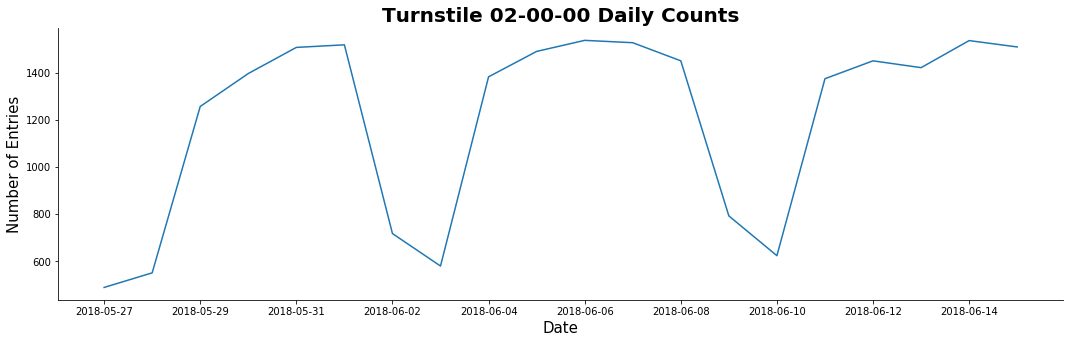

In [17]:
# Plot the figure
plt.figure(figsize=(18,5))
plt.plot(dates,count)
plt.title('Turnstile 02-00-00 Daily Counts', fontsize = 20, weight = 'bold')
plt.ylabel('Number of Entries', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
sns.despine()

> There are far fewer entries on the weekends than the weekdays

# Challenge 5  
For each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [18]:
# Group by ("C/A","UNIT","STATION","DATE") to find the total daily sum

comb_turnstiles = daily.groupby(["C/A","UNIT","STATION","DATE"],as_index=False)["DAILY_ENTRIES"].sum()

In [19]:
comb_turnstiles.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,2018-05-27,5306.0
1,A002,R051,59 ST,2018-05-28,5609.0
2,A002,R051,59 ST,2018-05-29,12526.0
3,A002,R051,59 ST,2018-05-30,13760.0
4,A002,R051,59 ST,2018-05-31,13911.0


# Challenge 6  
Combine everything in each station, and come up with a time series for each STATION.

In [20]:
# Group by station and date

comb_station = comb_turnstiles.groupby(["STATION","DATE"],as_index=False)["DAILY_ENTRIES"].sum()
comb_station.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2018-05-27,13287.0
1,1 AV,2018-05-28,12572.0
2,1 AV,2018-05-29,20723.0
3,1 AV,2018-05-30,22414.0
4,1 AV,2018-05-31,22932.0


In [21]:
# Create lists of each column

stations = comb_station["STATION"].values
dates = comb_station["DATE"].values
entries = comb_station["DAILY_ENTRIES"].values

In [22]:
# Create an empty dictionary
dictionary = {}

# Create a list of tuples with (station, date, entry) data
data = []
for station, date, entry in zip(stations,dates,entries):
    tup = (station, date, entry)
    data.append(tup)

# Create a dictionary of the values
for station, date, entry in data:
    tup = (date,entry)
    dictionary.setdefault(station, []).append(tup)

# Challenge 7  
Plot the time series for a station.

In [23]:
# Create lists of dates and entries for Kingston-Throop (my station)

dates = []
entries = []
for item in dictionary["KINGSTON-THROOP"]:
    dates.append(item[0])
    entries.append(item[1])

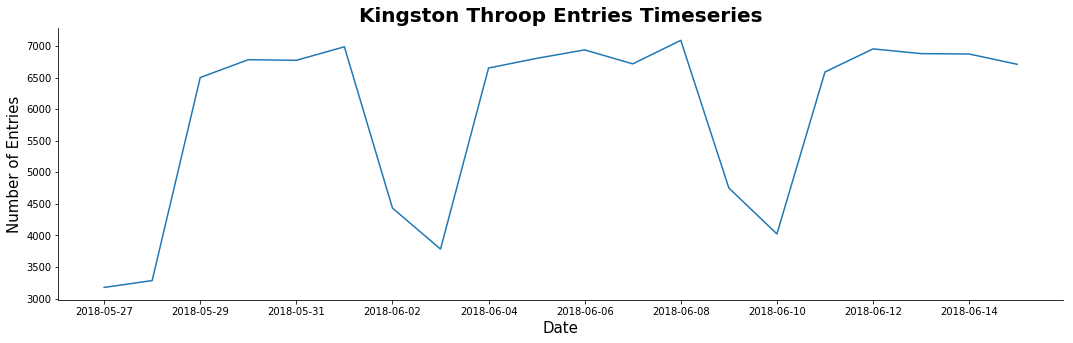

In [24]:
# Plot the graph
plt.figure(figsize=(18,5))
plt.plot(dates,entries)
plt.title('Kingston Throop Entries Timeseries', fontsize = 20, weight = 'bold')
plt.ylabel('Number of Entries', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
sns.despine()

> This plot looks very similar to the individual turnstile plot, which makes sense since overall traffic patterns in station should be similar to the patterns at an individual turnstile

# Challenge 8
Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [25]:
# Convert the date to a day of the week integer
comb_station["DATE"] = comb_station["DATE"].dt.weekday

In [26]:
# Extract Kingaton-Throop
mask = (comb_station["STATION"] == "KINGSTON-THROOP")
kingston = comb_station[mask]
kingston

,STATION,DATE,DAILY_ENTRIES
5240,KINGSTON-THROOP,6,3177.0
5241,KINGSTON-THROOP,0,3286.0
5242,KINGSTON-THROOP,1,6499.0
5243,KINGSTON-THROOP,2,6782.0
5244,KINGSTON-THROOP,3,6772.0
5245,KINGSTON-THROOP,4,6986.0
5246,KINGSTON-THROOP,5,4434.0
5247,KINGSTON-THROOP,6,3784.0
5248,KINGSTON-THROOP,0,6650.0
5249,KINGSTON-THROOP,1,6803.0


In [27]:
# Create a list of values from entries
entries = kingston["DAILY_ENTRIES"].values

In [28]:
# Separate the weeks
week1 = entries[0:7]
week2 = entries[7:14]
week3 = entries[14:21]

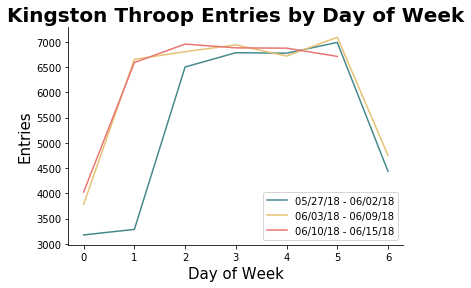

In [29]:
# Plot the weeks
plt.plot(week1, c = '#45898C', label = '05/27/18 - 06/02/18')
plt.plot(week2, c = '#E7C172', label = '06/03/18 - 06/09/18')
plt.plot(week3, c = '#E77572', label = '06/10/18 - 06/15/18');
plt.legend()
plt.title('Kingston Throop Entries by Day of Week', fontsize = 20, weight = 'bold')
plt.ylabel('Entries', fontsize = 15)
plt.xlabel('Day of Week', fontsize = 15)
sns.despine()

>By overlaying the individual weeks, we can see that each week has a simiar pattern, with far fewer entries on weekends than weekdays. The first week is a bit irregular, as the monday has more similar entry data to a weekend day. It turns out that that particular day, May 28th, 2018 was Memorial Day. So it makes sense that it's entry data seemed more like a weekend.

# Challenge 9  
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [30]:
# This code sorts the stations with the highest number of entries per day of week

# sum_comb_station = (comb_station
#                     .groupby(["DATE", "STATION"],as_index=False)["DAILY_ENTRIES"]
#                     .sum().sort_values(by = "DAILY_ENTRIES")
#                    )

# sum_comb_station.sort_values(["DATE","DAILY_ENTRIES"], inplace=True, ascending=False)

# total_station_counts = comb_station.group

In [31]:
# Sum all entries by station and sort them

comb_station = (comb_station
                .groupby(["STATION"],as_index=False)["DAILY_ENTRIES"]
                .sum()
                .sort_values(by = "DAILY_ENTRIES", ascending=False)
               )

In [32]:
comb_station.head(10)

,STATION,DAILY_ENTRIES
59,34 ST-PENN STA,2881421.0
230,GRD CNTRL-42 ST,2568415.0
57,34 ST-HERALD SQ,2162908.0
45,23 ST,1918476.0
14,14 ST-UNION SQ,1884382.0
350,TIMES SQ-42 ST,1871631.0
65,42 ST-PORT AUTH,1829066.0
223,FULTON ST,1664061.0
9,125 ST,1448505.0
107,86 ST,1413850.0


>"34 ST-PENN STA" seems to have the highest total entries in this period of time.

# Challenge 10

Make a single list of these total ridership values and plot it 


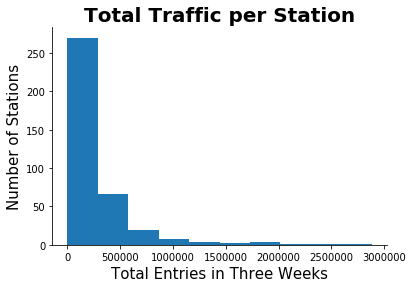

In [33]:
# Make a list of all items in the "DAILY_ENTRIES" column in the summed dataframe from before
total = comb_station["DAILY_ENTRIES"].values

# Plot it
plt.hist(total);
plt.title('Total Traffic per Station', fontsize = 20, weight = 'bold')
plt.ylabel('Number of Stations', fontsize = 15)
plt.xlabel('Total Entries in Three Weeks', fontsize = 15)
sns.despine()

> It's very clear that the large majoriity of stations don't get that much traffic on average (<170,000 per week or 24,000 per day). Only a tiny portion of stations get the majority of entries per day (although this really doesn't account for the size of those stations and number of lines through them compared with the smaller stations).

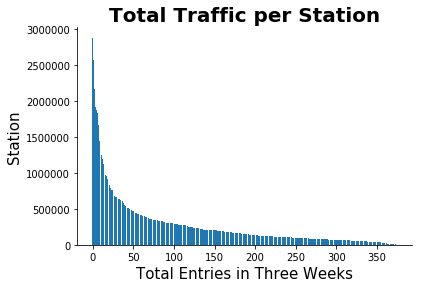

In [34]:
# Bar chart of the individual station total entries

indices = range(len(total))
plt.bar(indices, total);
plt.title('Total Traffic per Station', fontsize = 20, weight = 'bold')
plt.ylabel('Station', fontsize = 15)
plt.xlabel('Total Entries in Three Weeks', fontsize = 15)
sns.despine()

> By looking at the individual stations, it's clear that the top few stations take significantly more than all the rest.